In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook",font_scale=1.2)
import pandas as pd
# disable setting with copy warning
pd.options.mode.chained_assignment = None
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import pydicom

In [23]:
PV = "age"
if PV == "age":
    groups = ["old", "young"]
else:
    groups = ["male", "female"]
metric = (f"test/lungOpacity_{groups[0]}_subgroupAUROC", f"test/lungOpacity_{groups[1]}_subgroupAUROC", "subgroupAUROC")

In [24]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    sample_dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        # get last number from directory name
        train_loader_num = int(d.split('_')[-1])
        for seed in seeds:
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')][0]
            sample_info = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('train_loader')][0]
            results_df = pd.read_csv(os.path.join(d, seed, results))
            sample_df = pd.read_csv(os.path.join(d, seed, sample_info))
            results_df["train_loader_num"] = train_loader_num
            sample_df["train_loader_num"] = train_loader_num
            dfs.append(results_df)
            sample_dfs.append(sample_df)
    return pd.concat(dfs, ignore_index=True), pd.concat(sample_dfs, ignore_index=True)

In [25]:
dirs = [f for f in os.listdir('./') if os.path.isdir(os.path.join('./',f))]
data = {}
for model in ["FAE","RD"]:
    dfs = []
    for sample_size in [1,5,10,15]:
        sub_dir = [d for d in dirs if model in d and d.endswith(f"{sample_size}-noDP")][0]
        temp, _ = load_csvs_into_df(sub_dir)
        temp["num_samples"] = sample_size
        temp["model"] = model
        dfs.append(temp)
    data[model] = pd.concat(dfs, ignore_index=True)

In [26]:
df = pd.concat([data["FAE"], data["RD"]], ignore_index=True)
df = df[["test/lungOpacity_old_subgroupAUROC", f"test/lungOpacity_young_subgroupAUROC", "train_loader_num", "seed", "num_samples", "model"]]

In [27]:
df = df.melt(id_vars=["train_loader_num", "seed", "model","num_samples"], var_name="metric", value_name="value")

In [28]:
df.metric = df.metric.str.replace(metric[1],groups[1])
df.metric = df.metric.str.replace(metric[0],groups[0])

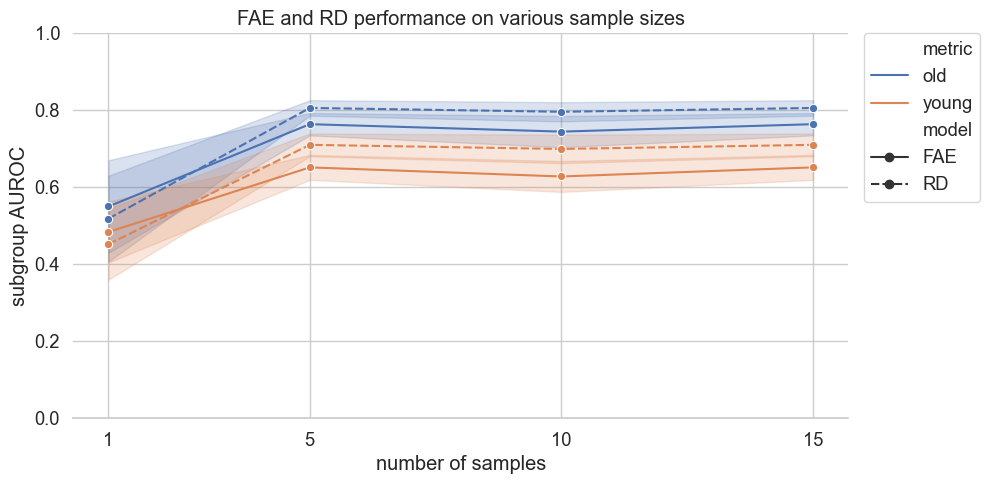

In [29]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(
    data = df,
    x = "num_samples",
    y = "value",
    hue = "metric",
    style="model",
    markers=["o", "o"],
    errorbar="sd",
)
g.set_title("FAE and RD performance on various sample sizes")
g.set_ylim([0, 1])
g.set_ylabel("subgroup AUROC")
g.set_xlabel("number of samples")
g.set_xticks([1,5,10,15])
sns.despine(left=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)